# Bicycle Inventory Dynamics - Part 1

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

import itertools
from dataclasses import dataclass

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import poisson

from rl.distributions import Constant, SampledDistribution
from rl.markov_process import MarkovRewardProcess, NonTerminal, State

In [2]:
@dataclass(frozen=True)
class Inventory:
    on_hand: int
    on_order: int

    @property
    def total_inventory(self) -> int:
        return self.on_hand + self.on_order


class BicycleInventoryMRP(MarkovRewardProcess[Inventory]):
    def __init__(
        self,
        capacity: int,
        poisson_lambda: float,
        holding_cost: float,
        stockout_cost: float,
    ) -> None:
        self.capacity = capacity
        self.poisson_lambda = poisson_lambda
        self.holding_cost = -holding_cost
        self.stockout_cost = -stockout_cost

    def transition_reward(
        self, state: NonTerminal[Inventory]
    ) -> SampledDistribution[tuple[State[Inventory], float]]:
        def sample_next_state_and_reward(
            state: NonTerminal[Inventory] = state,
        ) -> tuple[State[Inventory], float]:
            units_in_demand: int = poisson(self.poisson_lambda).rvs()
            total_inventory: int = state.state.total_inventory
            leftover_inventory: int = max(total_inventory - units_in_demand, 0)
            need_to_order: int = max(self.capacity - leftover_inventory, 0)
            excess_demand: int = max(units_in_demand - total_inventory, 0)

            next_state = Inventory(on_hand=leftover_inventory, on_order=need_to_order)

            reward = (
                self.holding_cost * state.state.on_hand
                + self.stockout_cost * excess_demand
            )

            return NonTerminal(next_state), reward

        return SampledDistribution(sampler=sample_next_state_and_reward)

In [3]:
mrp = BicycleInventoryMRP(
    capacity=10,
    poisson_lambda=7.0,
    holding_cost=70.0,
    stockout_cost=200.0,
)

What happens when the store starts out with 4 cycles in the inventory and has 3 on the way? What would the short-term costs be when starting from this?

In [13]:
state = NonTerminal(Inventory(on_hand=4, on_order=3))

traces: list[list[tuple[Inventory, Inventory, float]]] = [
    [
        (s.state.state, s.next_state.state, s.reward)
        for s in itertools.islice(
            mrp.simulate_reward(start_state_distribution=Constant(value=state)),
            1_000,
        )
    ]
    for _ in range(10)
]

In [18]:
stats = pd.DataFrame(
    {
        "On Hand": [s.on_hand for trace in traces for s, _, _ in trace],
        "On Order": [s.on_order for trace in traces for s, _, _ in trace],
        "Costs": [abs(r) for trace in traces for _, _, r in trace],
    }
)

stats = pd.pivot_table(
    data=stats,
    index="On Hand",
    columns="On Order",
    values="Costs",
    aggfunc="mean",
    dropna=False,
).sort_index(ascending=False)

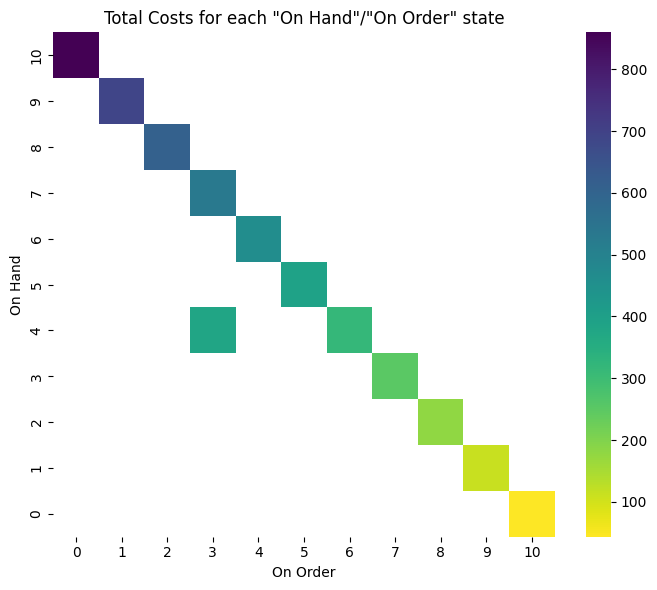

In [19]:
plt.subplots(figsize=(7, 6))
sns.heatmap(data=stats, cmap="viridis_r")
plt.title('Total Costs for each "On Hand"/"On Order" state')

plt.tight_layout()
plt.show()

Conclusion:         
In the long run, the least costs would be incurred when we're out of stock and will receive 10 cycles the next day.